In [ ]:
!pip install gpytorch

     |████████████████████████████████| 491kB 8.0MB/s 


In [ ]:
### Importing all libraries and modules
import copy

from datetime import datetime
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd
import numpy as np
import pickle

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import ApproximateGP

from torch.optim.lr_scheduler import StepLR

# Defining the Main GP model class
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
      """
      This initializes the model with some standard settings including the variational distribution to be used, the number of inducing points
      being used along with the mean and the covariance functions being used. 

      Below ConstantMean refers to the Mean being a constant. This means that the mean learnt will act as an offset of sorts whereas all the 
      variance in the data will be explained by the covariance function. The Mean can also be set to linear where it becomes a linear function
      of the features. 

      A basic RBF kernel has been used here that learns one lengthscale for all the dimensions. ScaleKernel below just imbues the RBF Kernel
      with a scalar scale value that can scale the value of the RBF kernel. 
      """
      variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
      variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
      super(GPModel, self).__init__(variational_strategy)
      self.mean_module = gpytorch.means.ConstantMean()
      self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
      """
      This is akin to the forward pass in Neural Nets in a way. Here the mean and the covariance functions are calculated on some given x.
      Then, using that mean and covariance function, a MultivariateNormal distribtuion is represented. 
      """
      mean_x = self.mean_module(x)
      covar_x = self.covar_module(x)
      return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#### functions for getting hyperparameter values (the details of these can be ignored)
def hyperparams_simple(model):
    """
    Print the models hyperparameters for hyperparameter exploration. Only works for kernels not using additive or product 
    kernels
    """
    kern_dict = {}
    current = model.covar_module
    count = 0
    while True:
        name = str(count) + "_" + str(type(current))[25:-2]
        children = get_children(current)
        cons_hp = [i for i in current.named_parameters_and_constraints()]
        kern_dict[name] = get_hp_dict(cons_hp)
        if children == []:
            break
        else:
            current = children[0][1]
        count += 1
    return pd.DataFrame(kern_dict).T
    
def get_children(current):
    children = []
    for i in current.named_children():
        if "kernel" not in i[0]:
            pass
        else:
            children.append(i)
    return children

def get_hp_dict(cons_hp):
    
    hp_dict = {}
    for i in cons_hp:
        if ("base_kernel" in i[0]) or ("kernels" in i[0]):
            pass
        else:
            curr_item = i[1]
            if curr_item.shape==():
                curr_item_list = [i[2].transform(curr_item)]
            else:
                curr_item_list = []
                for item in curr_item:
                    curr_item_list.append(i[2].transform(item)) 
            hp_dict[i[0][4:]] = curr_item_list[0].cpu().detach().numpy()
    return hp_dict

In [ ]:
# Creating a toy dataset
# There will be 1000 different rows where very hypothetical temperature and humidity will be the features which will be used to predict
# the even more hypothetical wind variable
 
cities = list(range(1000))
n= len(cities)
data = {'Temperature': np.random.normal(24, 3, n),
        'Humidity': np.random.normal(78, 2.5, n),
       }
df = pd.DataFrame(data=data, index=cities)
df["Wind"] = df.Temperature + df.Humidity + np.random.normal(0, 0.1, n) 
df

,Temperature,Humidity,Wind
0,18.350782,79.778918,98.100662
1,17.978290,75.509898,93.574344
2,24.245549,76.946228,101.227094
3,27.191908,76.802709,104.146112
4,26.713044,82.957483,109.841448
...,...,...,...
995,26.684666,75.748040,102.438072
996,26.507777,83.714309,110.110620
997,24.467574,77.134158,101.550195
998,24.046500,83.396481,107.384963


Text(0, 0.5, 'Wind')

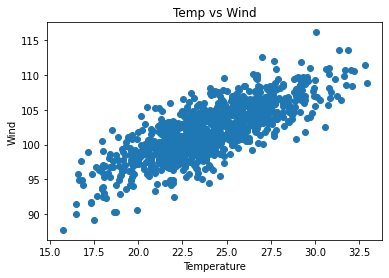

In [ ]:
plt.scatter(df.Temperature, df.Wind)
plt.title("Temp vs Wind")
plt.xlabel("Temperature")
plt.ylabel("Wind")

Text(0, 0.5, 'Wind')

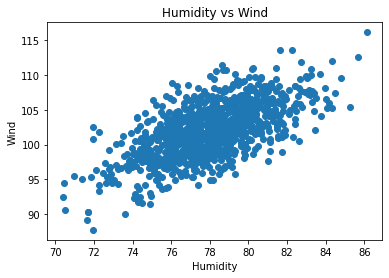

In [ ]:
plt.scatter(df.Humidity, df.Wind)
plt.title("Humidity vs Wind")
plt.xlabel("Humidity")
plt.ylabel("Wind")

In [ ]:
# some data related preprocessing for Gpytorch
train_x = df[["Temperature", "Humidity"]].values
train_y = df.Wind.values
train_x, train_y = torch.Tensor(train_x), torch.Tensor(train_y)

if torch.cuda.is_available():
    train_x, train_y = train_x.cuda(), train_y.cuda()

train_dataset = TensorDataset(train_x, train_y) 
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

In [ ]:
# Here we select the inducing points to be used
inducing_points = train_x[:500, :]
model = GPModel(inducing_points=inducing_points)
# The likelihood is learnt separate from the model. This refers to the epsilon/error term in the GP model formulation. 
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Below checks if the cuda/GPU is avaliable or not. If it is, then the model and likelihood both are transferred to the GPU
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [ ]:
# Now we set both to training mode
model.train()
likelihood.train()

# The use of an optimizer is again very similar to how it is used in neural nets. lr is learning rate.
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.05)

# Our loss object. We're using the VariationalELBO. This defines the loss function we are tryi ng to optimize
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

num_epochs = 500                  ############ please change this if you want to increase or decrease train time ############ 
epochs_iter = range(num_epochs)
for i in epochs_iter:
    count = 0
    mean_loss = 0
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = train_loader
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        count+=1
    if i%10 == 0:
      print("Mean Loss for Epoch", i,":", mean_loss/count)    

Mean Loss for Epoch 0 : 6991.33095703125
Mean Loss for Epoch 10 : 1880.3463623046875
Mean Loss for Epoch 20 : 689.5436157226562
Mean Loss for Epoch 30 : 298.8431457519531
Mean Loss for Epoch 40 : 164.89541931152343
Mean Loss for Epoch 50 : 110.53347625732422
Mean Loss for Epoch 60 : 81.35429229736329
Mean Loss for Epoch 70 : 65.83657455444336
Mean Loss for Epoch 80 : 55.3259162902832
Mean Loss for Epoch 90 : 48.00375518798828
Mean Loss for Epoch 100 : 42.28669128417969
Mean Loss for Epoch 110 : 38.435523986816406
Mean Loss for Epoch 120 : 36.3560073852539
Mean Loss for Epoch 130 : 33.798316955566406
Mean Loss for Epoch 140 : 32.039005279541016
Mean Loss for Epoch 150 : 29.75288314819336
Mean Loss for Epoch 160 : 29.857290267944336
Mean Loss for Epoch 170 : 27.42790298461914
Mean Loss for Epoch 180 : 26.321685791015625
Mean Loss for Epoch 190 : 25.798586273193358
Mean Loss for Epoch 200 : 24.392546463012696
Mean Loss for Epoch 210 : 22.880017852783205
Mean Loss for Epoch 220 : 22.160988

In [ ]:
# final hyperparameter values
hyperparams_simple(model)

,outputscale,lengthscale
0_scale_kernel.ScaleKernel,17.15954,NaN
1_rbf_kernel.RBFKernel,NaN,[1.6763567]


In [ ]:
model(train_x[:1, :])

MultivariateNormal(loc: tensor([98.4446], device='cuda:0', grad_fn=<AddBackward0>))